In [106]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import altair as alt
#alt.renderers.enable('notebook')
import seaborn as sns
import re
import os, sys
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from collections import Counter
from pyvis.network import Network
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google_trans_new import google_translator
from textblob import TextBlob
import time

# insert dir of python code in the path
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas.cabral\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas.cabral\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [2]:
module_path

'C:\\Users\\lucas.cabral\\saude_mental_pescadoras'

# Carrega e pré-processa dados

In [42]:
from docx import Document
import os
import re

def get_text(filename):
    doc = Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

docs_list = os.listdir('../data')
interviews = []
interviewees = []
titles = []
for doc_name in docs_list:
    print(doc_name, end= ' ')
    doc_path = os.path.join('..','data',doc_name)
    interview = get_text(doc_path)
    # parse interviewee
    interview = interview.replace('Marisqueiras: ', 'Marisqueira: ')
    lines_split = interview.split('Pesquisadora: ')
    interviewee = ''
    n_lines = len(re.findall(r'Marisqueira: ', interview.replace('\n',' ')))
    count = 0
    for line in lines_split:
        answer = line.split('Marisqueira: ')
        if len(answer)>1:
            interviewee += ' '.join(answer[1:])
            count+=len(answer[1:])
    print(n_lines,count)
    
    interviewees.append(interviewee)
    interviews.append(interview)
    titles.append(doc_name.replace('.docx',''))


Canavieiras 1.docx 16 16
Canavieiras 2.docx 14 14
Cumbe 1.docx 74 74
Cumbe 2.docx 11 11
Jardins 1.docx 53 53
Jardins 2.docx 16 16
Jardins 3.docx 18 18
Jardins 4.docx 20 20


In [43]:
df = pd.DataFrame({'título':titles, 'entrevista':interviews, 'respostas':interviewees})
df

,título,entrevista,respostas
0,Canavieiras 1,Canavieiras 1 \n\nPesquisadora: Pedi sua autor...,"Assim foi. Impactou muito, né? Porque a gente ..."
1,Canavieiras 2,Canavieiras 2 \nPesquisadora: Só a sua tua aut...,"Eu autorizo.\n\nO primeiro foi muito ruim, né?..."
2,Cumbe 1,Cumbe 1\n\nPesquisadora: Só pedir o teu aceite...,"Aham, concordo\n\nUhum. É, eu digo né. Que… re..."
3,Cumbe 2,Cumbe 2 23 de jun. 15.01_.aac\nPesquisadora: S...,"Ok, autorizo.\n\nAssim como aqui a gente veve ..."
4,Jardins 1,\nJardins 1\n\nPesquisadora: Ai só confirmar c...,Do… de… do óleo né?\n\nDo óleo a gente… A gent...
5,Jardins 2,Jardins 2 \n\nPesquisadora: Você pode só dizer...,"Eu, Otacília, a carne de Albuquerque autorizo ..."
6,Jardins 3,"Jardins 3 \nPesquisadora: Pronto, iniciando a ...","Sim. Pronto.\n\nÉ assim. Primeiramente, boa ta..."
7,Jardins 4,Jardins 4 \n\nPesquisadora: Sua autorização pr...,"Não, é claro.\n\nA gente foi atingido principa..."


## Processamento

In [44]:
# normalização e palavras chave
df['resposta normalizada'] = [preprocess(text) for text in df['respostas']]
df['palavras-chave'] = [get_keywords(text, 3) for text in df['resposta normalizada']]
# tamanho dos textos
df['número de palavras'] = [len(string.split()) for string in df['respostas']]
df['número de caracteres'] = [len(string) for string in df['respostas']]
# razão entre o número de palavras únicas e o número de palavras no texto
df['variabilidade léxica'] = [len(set(string.split()))/len(string.split()) for string in df['respostas']]
df

,título,entrevista,respostas,resposta normalizada,palavras-chave,número de palavras,número de caracteres,variabilidade léxica
0,Canavieiras 1,Canavieiras 1 \n\nPesquisadora: Pedi sua autor...,"Assim foi. Impactou muito, né? Porque a gente ...",assim impactou porque gente sobrevive marisco ...,"gente, não, também",548,3143,0.547445
1,Canavieiras 2,Canavieiras 2 \nPesquisadora: Só a sua tua aut...,"Eu autorizo.\n\nO primeiro foi muito ruim, né?...",autorizo primeiro ruim porque coisa desconheci...,"gente, não, porque",860,4589,0.423256
2,Cumbe 1,Cumbe 1\n\nPesquisadora: Só pedir o teu aceite...,"Aham, concordo\n\nUhum. É, eu digo né. Que… re...",aham concordo uhum digo que… realmente derrama...,"gente, não, nós",6347,34551,0.274460
3,Cumbe 2,Cumbe 2 23 de jun. 15.01_.aac\nPesquisadora: S...,"Ok, autorizo.\n\nAssim como aqui a gente veve ...",autorizo assim aqui gente veve pesca marisco e...,"gente, não, também",1664,9397,0.364784
4,Jardins 1,\nJardins 1\n\nPesquisadora: Ai só confirmar c...,Do… de… do óleo né?\n\nDo óleo a gente… A gent...,do… de… óleo óleo gente… gente ficou… gente so...,"gente, não, aqui",2421,12594,0.319703
5,Jardins 2,Jardins 2 \n\nPesquisadora: Você pode só dizer...,"Eu, Otacília, a carne de Albuquerque autorizo ...",otacília carne albuquerque autorizo gravação t...,"não, porque, gente",871,4866,0.486797
6,Jardins 3,"Jardins 3 \nPesquisadora: Pronto, iniciando a ...","Sim. Pronto.\n\nÉ assim. Primeiramente, boa ta...",sim pronto assim primeiramente boa tarde porqu...,"gente, não, porque",1824,9725,0.322368
7,Jardins 4,Jardins 4 \n\nPesquisadora: Sua autorização pr...,"Não, é claro.\n\nA gente foi atingido principa...",não claro gente atingido principalmente vendas...,"não, gente, porque",1382,7676,0.457308


# Termos

In [45]:
lyrics = ' '.join(df['resposta normalizada'])
tokens = lyrics.split()
count_tokens = Counter(tokens)
df_term = pd.DataFrame(list(count_tokens.items()), columns = ["termo","frequencia"])
df_term = df_term.sort_values(by='frequencia', ascending=False)
df_term

,termo,frequencia
3,gente,452
22,não,387
2,porque,185
0,assim,121
135,nós,118
...,...,...
1228,adoeça,1
518,coisa…,1
517,divulgado,1
1231,proximo,1


In [46]:
# conta a frequência dos termos
lyrics = ' '.join(df['resposta normalizada'])
tokens = lyrics.split()
count_tokens = Counter(tokens)
df_term = pd.DataFrame(list(count_tokens.items()), columns = ["termo","frequencia"])
df_term = df_term.sort_values(by='frequencia', ascending=False)

# músicas onde ocorrem
songs_by_term = []
number_of_songs_by_term = []
for term in df_term['termo']:
    songs = []
    for song, lyric in (zip(df['título'], df['resposta normalizada'])):
        if term in lyric.split():
            songs.append(song)

    number_of_songs_by_term.append(len(songs))
    songs = ' '.join(songs)
    songs_by_term.append(songs)

df_term['número de entrevistas onde o termo ocorre'] = number_of_songs_by_term
df_term['entrevistas onde o termo ocorre'] = songs_by_term

df_term.head(10)


,termo,frequencia,número de entrevistas onde o termo ocorre,entrevistas onde o termo ocorre
3,gente,452,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
22,não,387,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
2,porque,185,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
0,assim,121,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
135,nós,118,7,Canavieiras 1 Cumbe 1 Cumbe 2 Jardins 1 Jardin...
63,aqui,90,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
52,também,90,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
12,então,78,7,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
186,comunidade,58,7,Canavieiras 2 Cumbe 1 Cumbe 2 Jardins 1 Jardin...
149,pessoas,57,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...


In [47]:
# músicas onde mais ocorrem hapaxes
hapaxes = set(df_term[df_term['frequencia']==1]['termo'])
print('quantidade de hapaxes:', len(hapaxes))

hapaxes_count = []
for lyric in df['resposta normalizada']:
    tokens = set(lyric.split())
    count = len(tokens.intersection(hapaxes))
    hapaxes_count.append(count)

df['hapaxes'] = hapaxes_count

quantidade de hapaxes: 1033


# Termos mais frequentes

In [9]:
viz_path = os.path.join(module_path,'plots')
viz_path

'C:\\Users\\lucas.cabral\\saude_mental_pescadoras\\plots'

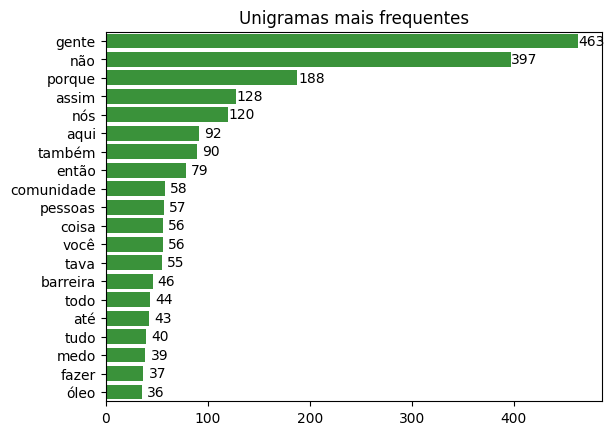

In [160]:
# unigramas
texts = ' '.join(list(df['resposta normalizada']))
n_grams = (1,1)
total_bigrams = build_ngram_df(texts, ngram = n_grams, n=20)
plt.title('Unigramas mais frequentes')
plot_ngrams(total_bigrams, col='C2', orientation = 'vertical')
plt.savefig(os.path.join(viz_path,'unigramas.jpg'))

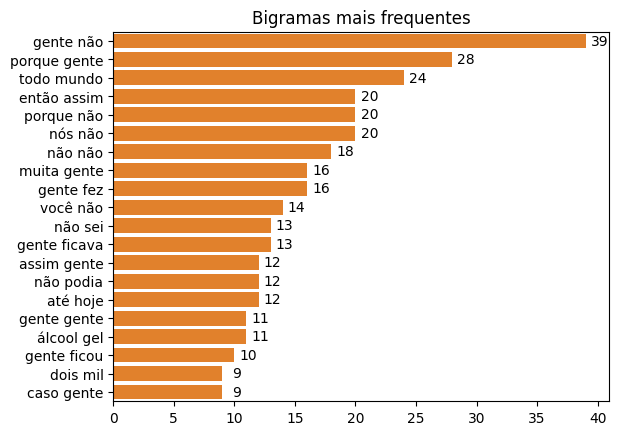

In [161]:
n_grams = (2,2)
total_bigrams = build_ngram_df(texts, ngram = n_grams, n=20)
plt.title('Bigramas mais frequentes')
plot_ngrams(total_bigrams, col='C1', orientation = 'vertical')
plt.savefig(os.path.join(viz_path,'bigramas.jpg'))

## Adjetivos mais frequentes

In [130]:
import joblib
from nltk import word_tokenize
tagger_path = os.path.join(module_path,'res','POS_tagger_brill.pkl')
tagger = joblib.load(tagger_path)
phrase = 'O lindo rato roeu lindamente a roupa do rei de Roma'
tagger.tag(word_tokenize(phrase))

[('O', 'ART'),
 ('lindo', 'ADJ'),
 ('rato', 'N'),
 ('roeu', 'V'),
 ('lindamente', 'ADV'),
 ('a', 'ART'),
 ('roupa', 'N'),
 ('do', 'KS'),
 ('rei', 'N'),
 ('de', 'PREP'),
 ('Roma', 'NPROP')]

In [136]:
adjs = ''
for text in df['respostas']:
    tags = tagger.tag(word_tokenize(text))
    for tag in tags:
        if tag[1]=='ADJ':
            adjs += tag[0] + ' '

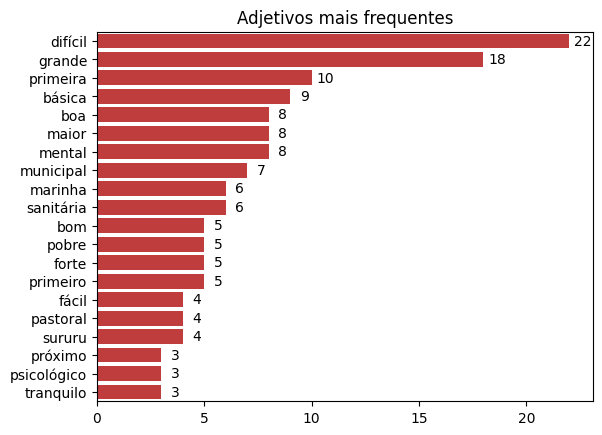

In [137]:
# adjetivos mais frequentes
n_grams = (1,1)
total_bigrams = build_ngram_df(adjs, ngram = n_grams, n=20)
plt.title('Adjetivos mais frequentes')
plot_ngrams(total_bigrams, col='C3', orientation = 'vertical')
plt.savefig(os.path.join(viz_path,'adjetivos.jpg'))

In [138]:
# adj + sub
adj_sub = []
for text in df['respostas']:
    tags = tagger.tag(word_tokenize(text))
    for i, tag in enumerate(tags):
        if tag[1]=='ADJ':
            if i-1 > 0: #and tags[i-1][1] == 'N':
                adj_sub.append((tags[i-1][0], tag[0]))
            elif i+1 < len(tags): #and tags[i-1][1] == 'N':
                adj_sub.append((tags[i+1][0], tag[0]))

In [166]:
# adj + sub
# adj_sub = []
# for text in df['respostas']:
#    tags = tagger.tag(word_tokenize(text))
#    for i, tag in enumerate(tags):
#        if tag[1]=='ADJ':
#            if i-1 > 0 and i+1 < len(tags):
#                adj_sub.append((tags[i-1][0], tag[0], tags[i+1][0]))
#            elif i-1 > 0:
#                adj_sub.append((tags[i-1][0], tag[0]))
#            elif i+1 < len(tags): #and tags[i-1][1] == 'N':
#                adj_sub.append((tags[i+1][0], tag[0]))
#Counter(adj_sub).most_common(20)

In [156]:
from collections import Counter
count = Counter(adj_sub).most_common(15)
labels = []
values = []
for c in count:
    labels.append(c[0][0] + ' ' + c[0][1])
    values.append(c[1])

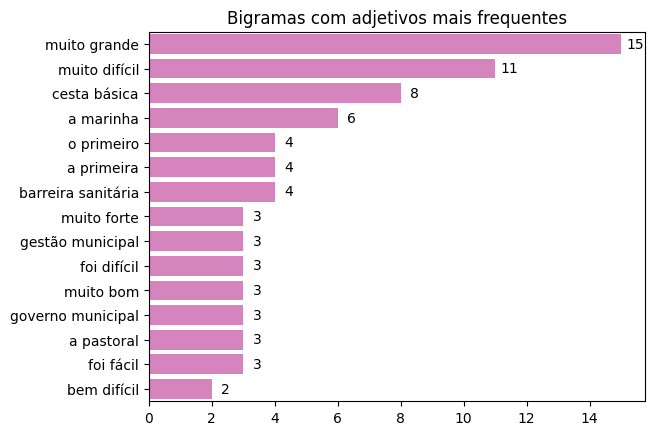

In [162]:
col = 'C6' 
orientation = 'vertical'
plt.title('Bigramas com adjetivos mais frequentes')

#
if orientation == 'vertical':
    g = sns.barplot(y=labels, x=values, color = col)
    for p in g.patches:
        g.annotate(format(p.get_width(), '.0f'), (p.get_width(), 
                                                   p.get_y() + p.get_height()/2.), ha = 'center', 
                   va = 'center', xytext = (10, 0), textcoords = 'offset points')
else:
    plt.xticks(values, labels, rotation='vertical')
    g = sns.barplot(x=labels, y=values, color = col) 
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
        
plt.savefig(os.path.join(viz_path,'adjetivos_bigramas.jpg'))

# Tamanho das entrevistas

In [12]:
brush = alt.selection(type='interval')
pts = alt.selection(type="interval", encodings=["x"])

rowbars = alt.Chart(df).mark_bar().encode(
    x='número de palavras:Q',
    y= alt.Y('título:O', sort = alt.EncodingSortField(field="número de palavras", order='descending')),   
    tooltip=['título', 'número de palavras', 'palavras-chave','respostas']
).transform_filter(
    brush
).transform_filter(
    pts
).properties(    
    height= 800,
    width = 300,
    title = 'Quantidade de palavras de cada entrevista'
)


hist_len = alt.Chart(df).mark_bar().encode(
    x = alt.X('número de palavras:Q', bin=alt.Bin(maxbins=30), title='Quantidade de palavras'),
    y = alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Quantidade de entrevistas')]
    #color = alt.condition(pts, alt.value("darkgray"), alt.value("lightgray"))
).properties(
    width = 320,
    height = 200,
    title = 'Histograma da quantidade de palavras por entrevista'
).add_selection(pts)

hist_lex = alt.Chart(df).mark_bar().encode(
    x = alt.X("variabilidade léxica:Q", bin=alt.Bin(maxbins=30),title = 'variabilidade léxica'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da variabilidade léxica'
).add_selection(pts)

hist_hap = alt.Chart(df).mark_bar().encode(
    x = alt.X("hapaxes:Q", bin=alt.Bin(maxbins=30),title = 'quantidade de hapaxes'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma de quantidade de hapaxes'
).add_selection(pts)

points = alt.Chart(df).mark_circle().encode(
    x='número de palavras:Q',
    y='variabilidade léxica:Q',
    tooltip=['título','número de palavras','variabilidade léxica','respostas'],
    size='hapaxes:Q'
).properties(    
    title = 'Número de palavras por variabilidade léxica'
).add_selection(
    brush
).transform_filter(
    pts
)

hconcat = alt.hconcat(
    rowbars,
    hist_len,
    hist_lex,
    hist_hap,
    points,
    data=df
)

hconcat = (rowbars | (hist_len & hist_lex & hist_hap) | points)

file = 'palavras_por_entrevista.html'
filepath = os.path.join(viz_path, file)
hconcat.save(filepath)
hconcat


alt.HConcatChart(...)

# Frequência das palavras

In [13]:
df_term.head(2)

,termo,frequencia,número de entrevistas onde o termo ocorre,entrevistas onde o termo ocorre
3,gente,452,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...
22,não,387,8,Canavieiras 1 Canavieiras 2 Cumbe 1 Cumbe 2 Ja...


In [14]:
df_most_f = df_term.sort_values(by = 'frequencia', ascending = False)[0:50]
df_most_l = df_term.sort_values(by = 'número de entrevistas onde o termo ocorre', ascending = False)[0:50]


word_freq = alt.Chart(df_most_f).mark_bar().encode(
    x='frequencia:Q',
    y= alt.X('termo:O', sort = alt.EncodingSortField(field="frequencia", order='descending')),
    color = alt.value('steelblue'),
    tooltip=[
        'termo:O',
        'frequencia:Q',
        alt.Tooltip('entrevistas onde o termo ocorre:O', title='Entrevistas onde o termo ocorre')
    ]
).properties(    
    height=850,
    width = 300,
    title = 'Termos mais frequentes no total'
)

lyrics_count = alt.Chart(df_most_l).mark_bar().encode(
    x='número de entrevistas onde o termo ocorre:Q',
    y= alt.X('termo:O', 
                sort = alt.EncodingSortField(field="número de entrevistas onde o termo ocorre", order='descending')),
    color = alt.value('steelblue'),
    tooltip=[
        'termo:O',
        'número de entrevistas onde o termo ocorre:Q',
        alt.Tooltip('entrevistas onde o termo ocorre:O', title='Entrevistas onde o termo ocorre')
    ]
).properties(    
    height=850,
    width = 300,
    title = 'Termos que ocorrem em mais entrevistas'
)

hconcat = alt.hconcat(
    word_freq,
    lyrics_count,
)

hconcat = (word_freq | lyrics_count)

file = 'frequencia_dos_termos.html'
filepath = os.path.join(viz_path, file)
hconcat.save(filepath)
hconcat

alt.HConcatChart(...)

In [15]:
# hapaxes
hapaxes_df = df_term[df_term['frequencia']==1]
print('Total de hapaxes:', len(hapaxes_df))
for hapaxe, lyrics in zip(hapaxes_df['termo'], hapaxes_df['entrevistas onde o termo ocorre']):
    print(hapaxe + ': ' + lyrics)

Total de hapaxes: 1033
isolar: Jardins 1
catavam: Canavieiras 2
achavam: Jardins 1
ai…: Jardins 1
entrega: Jardins 1
adoecia: Jardins 1
conviveu: Jardins 1
comigo: Jardins 1
perguntando: Canavieiras 2
quando…: Jardins 1
coiso: Jardins 1
botasse: Jardins 1
quero: Jardins 1
pelo…: Jardins 1
tensa: Canavieiras 2
prometeram: Jardins 1
convive: Jardins 1
hoje…: Jardins 1
dizer…: Jardins 1
sintoma: Jardins 1
crise…: Jardins 1
rouquidão: Jardins 1
somo…: Jardins 1
cea…: Jardins 1
saísse: Jardins 1
pés: Jardins 1
febre: Jardins 1
aguentar: Jardins 1
imaginar: Canavieiras 2
sustentava: Canavieiras 2
frio: Jardins 1
nem…: Jardins 1
perdi: Jardins 1
paladar: Jardins 1
vier: Jardins 1
protegido: Jardins 1
chão: Jardins 1
diminuído: Jardins 1
sentisse: Jardins 1
almoçar: Jardins 1
gaiatim: Jardins 1
jardins…: Jardins 1
tradicionais: Canavieiras 2
dormir: Jardins 1
morre: Jardins 1
ganhou: Jardins 1
ligeirim: Jardins 1
sapato: Jardins 1
vizinho: Jardins 1
morro: Jardins 1
mortalidade: Canavieiras 2


# Matriz de similaridade

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(df['resposta normalizada']))
cosine_sim = cosine_similarity(X,X)
df_similar = pd.DataFrame(cosine_sim, columns = df['título'], index = df['título'])
df_similar['título'] = df['título']

source = df_similar.melt(id_vars=['título'])
source.columns = ['entrevista i', 'entrevista j', 'similaridade']
source['entrevista j'] = list(df['título'])*len(df['título'])
source.head()

,entrevista i,entrevista j,similaridade
0,Canavieiras 1,Canavieiras 1,1.000000
1,Canavieiras 1,Canavieiras 2,0.541840
2,Canavieiras 1,Cumbe 1,0.500030
3,Canavieiras 1,Cumbe 2,0.558698
4,Canavieiras 1,Jardins 1,0.521453


In [17]:
alt.data_transformers.disable_max_rows()
matrix_sim = alt.Chart(source).mark_rect().encode(
    x='entrevista i:O',
    y='entrevista j:O',
    color=alt.Color('similaridade:Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('entrevista i:O', title='i'),
        alt.Tooltip('entrevista j:O', title='j'),
        alt.Tooltip('similaridade:Q', title='Similaridade'),
    ]
).properties(    
    width = 500,
    height= 500,    
    title = 'Matriz de similaridade entre entrevistas'
)

file = 'similaridade.html'
filepath = os.path.join(viz_path, file)
matrix_sim.save(filepath)
matrix_sim

alt.Chart(...)

# Grafo de co-ocorrência

In [99]:
bigrams = build_ngram_df(df['resposta normalizada'], ngram = (2,2), n=None,)
max_range = 200

ngrams = [(t.split()[0],t.split()[1]) for t in bigrams.index[0:max_range]]
values = [int(i) for i in bigrams.values[0:max_range]]
d = dict(zip(ngrams,values))

net = Network(width = '1250', height = '800px',notebook = True, directed=True)
# Create connections between nodes
for k in d:
    #print(k[0] + "," + k[1] + str(d[k]))
    net.add_node(k[0], label = k[0], value = d[k])
    net.add_node(k[1], label = k[1], value = d[k])
    net.add_edge(k[0], k[1], weight = d[k])

#net.show_buttons(filter_=['physics'])
file = 'network.html'
filepath = os.path.join(viz_path, file)
net.save_graph(file)
print('saved')
net.show(file)

saved
network.html


# Análise de sentimentos

In [86]:
from libretranslatepy import LibreTranslateAPI
import time
lt = LibreTranslateAPI("https://translate.argosopentech.com/")
#if 'tradução' not in df.columns:
translated_aswers = []
for interviewee in list(df['respostas']):
    translated = []
    for line in interviewee.split('\n'):
        if len(line)>0:
            line_trans = lt.translate(line, "pt", "en")
            #print(line_trans)
            translated.append(line_trans)
            time.sleep(0.5)
            print()
    translated = '\n'.join(translated)
    translated_aswers.append(translated)

df['tradução'] = translated_aswers
df.to_csv(os.path.join(module_path, 'data', 'entrevistas.csv'),index=False)
        

In [88]:
def classify_sentiment(pol):
    if pol >= 0.1:
        return 'Positivo'
    elif pol >= -0.1:
        return 'Neutro'
    else:
        return 'Negativo'
    
titles = []
lines = []   
polarities = []
subjectivities = []
for text, title in zip(df['tradução'],df['título']):
    for line in text.split('\n'):
        if len(line) > 0:
            blob = TextBlob(line)
            polarities.append(blob.sentiment.polarity) 
            subjectivities.append(blob.sentiment.subjectivity)
            titles.append(title)
            lines.append(line)

sent = [classify_sentiment(x) for x in polarities]
n_words = [len(x.split(' ')) for x in lines]
df_sent = pd.DataFrame({'sentimento':sent, 'polaridade':polarities, 'subjetividade':subjectivities,
                       'número de palavras':n_words, 'título':titles, 'respostas': lines})

In [89]:
df_sent

,sentimento,polaridade,subjetividade,número de palavras,título,respostas
0,Negativo,-0.101948,0.570779,104,Canavieiras 1,"so it was. It's impacted a lot, right? Because..."
1,Positivo,0.225000,0.266667,10,Canavieiras 1,"it wasn't as much as the first, but it impacted."
2,Neutro,0.000000,0.125000,3,Canavieiras 1,this same insecurity
3,Neutro,0.040000,0.260000,39,Canavieiras 1,"not so much physics, but the mental yes. a lot..."
4,Positivo,0.142857,0.267857,4,Canavieiras 1,I'll be right back.
...,...,...,...,...,...,...
218,Neutro,0.031548,0.511756,104,Jardins 4,"No, it was the sema, we were invited to attend..."
219,Positivo,0.470899,0.553862,100,Jardins 4,the challenge we had was to raise awareness of...
220,Neutro,-0.005000,0.512500,111,Jardins 4,I can't even tell you if I got any results fro...
221,Neutro,0.000000,0.000000,2,Jardins 4,That's it.


In [90]:
# visualização interativa

brush = alt.selection(type='interval')

pts = alt.selection(type="interval", encodings=["x"])

points = alt.Chart(df_sent).mark_circle().encode(
    x='polaridade:Q',
    y='subjetividade:Q',
    color=alt.condition(brush, 'sentimento:N', alt.value('lightgray')),
    tooltip=['título','polaridade','subjetividade','respostas'],
    size='número de palavras:Q'
).properties(    
    title = 'Polaridade x Subjetividade'
).add_selection(
    brush
).transform_filter(
    pts
)

bars = alt.Chart(df_sent).mark_bar().encode(
    y=alt.Y('sentimento:N', title = 'Categorias de polaridade'),
    color='sentimento:N',
    x=alt.X('count(sentimento):Q', title = 'Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    title = 'Categorias de Polaridade'
).transform_filter(
    brush
).transform_filter(
    pts
)

hist_pol = alt.Chart(df_sent).mark_bar().encode(
    x = alt.X("polaridade:Q", bin=alt.Bin(maxbins=30),title = 'polaridade'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
    color = alt.condition(pts, 'sentimento:N', alt.value("lightgray"))
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da polaridade'
).add_selection(pts)


hist_sub = alt.Chart(df_sent).mark_bar().encode(
    x = alt.X("subjetividade:Q", bin=alt.Bin(maxbins=30),title = 'subjetividade'),
    y =alt.Y('count()',title = 'Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
    color = alt.condition(pts, alt.value("lightblue"), alt.value("lightgray"))
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da subjetividade'
).add_selection(pts)

sent = alt.hconcat(
    points & bars,
    hist_pol & hist_sub,
    data=df
)

pol = alt.Chart(df_sent).mark_bar().encode(
    y="polaridade:Q",
    x= alt.X("título:O", sort = alt.EncodingSortField(field="polaridade", order='descending')),
    tooltip = ['título','polaridade','respostas'],
    color= 'sentimento'
).properties(
    width=800,
    height = 300,
    title = 'Polaridade das entrevistas'
).transform_filter(
    pts
)

sent = ((points & bars) | (hist_sub & hist_pol)) & pol
sent.properties(title = 'Análise de Sentimentos')
file = 'analise_sentimentos.html'
filepath = os.path.join(viz_path, file)
sent.save(filepath)
sent

alt.VConcatChart(...)